## Feature Extraction

In [3]:
import pandas as pd
import numpy as np
from numpy import array

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils import shuffle
import matplotlib.pyplot as plt


from numpy.random import seed

seed(1652)
tf.set_random_seed(432)

pd.set_option('display.max_rows', None)
# ACCELEROMETER, GYROSCOPE, GRAVITY, ROTATION_VECTOR

In [4]:
n_steps=50
n_features=12

In [5]:
raw1_df = pd.read_csv("data/measures_1.csv", header=None, names=("t", "s1", "v11", "v12", "v13", "s2", "v21", "v22", "v23", "s3", "v31", "v32", "v33", "s4", "v41", "v42", "v43"))
raw2_df = pd.read_csv("data/measures_3.csv", header=None, names=("t", "s1", "v11", "v12", "v13", "s2", "v21", "v22", "v23", "s3", "v31", "v32", "v33", "s4", "v41", "v42", "v43"))


In [8]:
df1 = raw1_df[["v11", "v12", "v13", "v21", "v22", "v23", "v31", "v32", "v33", "v41", "v42", "v43"]]
df2 = raw2_df[["v11", "v12", "v13", "v21", "v22", "v23", "v31", "v32", "v33", "v41", "v42", "v43"]]

df1.loc[:, 'target'] = 0
df2.loc[:, 'target'] = 1

In [10]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [11]:
df1arr = df1.to_numpy()
df1arr_train = df1arr[int(df1arr.shape[0]*0.25):]
df1arr_test  = df1arr[:int(df1arr.shape[0]*0.25)]

In [12]:
df2arr = df2.to_numpy()
df2arr_train = df2arr[int(df2arr.shape[0]*0.25):]
df2arr_test  = df2arr[:int(df2arr.shape[0]*0.25)]

In [13]:
X1_train, y1_train = split_sequences(df1arr_train, n_steps)
X2_train, y2_train = split_sequences(df2arr_train, n_steps)

y1_train = y1_train.reshape(y1_train.shape[0], 1)
y2_train = y2_train.reshape(y2_train.shape[0], 1)

In [14]:
X1_test, y1_test = split_sequences(df1arr_test, n_steps)
X2_test, y2_test = split_sequences(df2arr_test, n_steps)

y1_test = y1_test.reshape(y1_test.shape[0], 1)
y2_test = y2_test.reshape(y2_test.shape[0], 1)

In [16]:
X_train = np.vstack((X1_train, X2_train))
y_train = np.vstack((y1_train, y2_train))

In [17]:
X_test = np.vstack((X1_test, X2_test))
y_test = np.vstack((y1_test, y2_test))

In [18]:

X_train, y_train = shuffle(X_train, y_train, random_state=0)

## Visualizing data

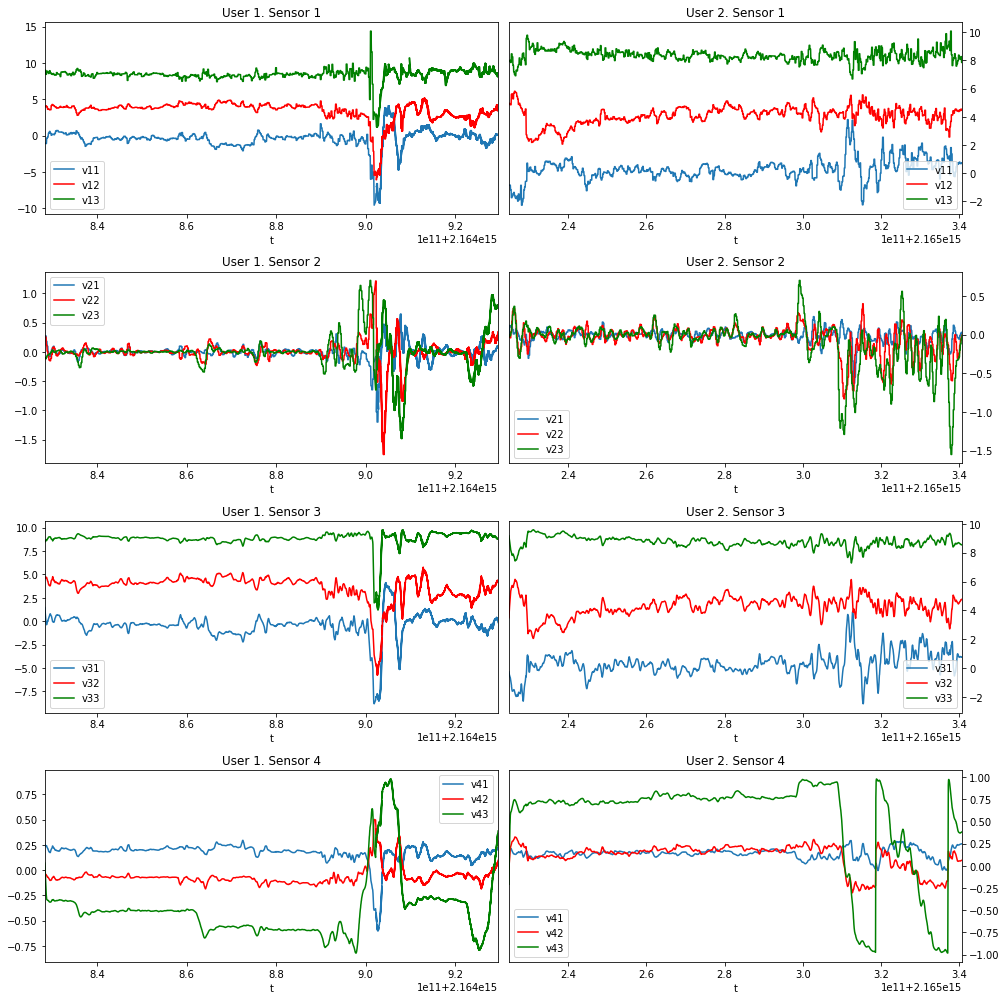

In [19]:

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,14))

for i in range(4):
    i += 1
    idx1 = "v{}1".format(i)
    idx2 = "v{}2".format(i)
    idx3 = "v{}3".format(i)
    ax1 = ax[i-1][0]
    ax2 = ax[i-1][1]
    
    raw1_df.plot(kind='line',x='t',y=idx1, ax=ax1)
    raw1_df.plot(kind='line',x='t',y=idx2, color='red', ax=ax1)
    raw1_df.plot(kind='line',x='t',y=idx3, color='g', ax=ax1)
    ax1.set_title("User {}. Sensor {}".format(1, i))
    
    raw2_df.plot(kind='line',x='t',y=idx1,ax=ax2)
    raw2_df.plot(kind='line',x='t',y=idx2, color='red', ax=ax2)
    raw2_df.plot(kind='line',x='t',y=idx3, color='g', ax=ax2)
    ax2.set_title("User {}. Sensor {}".format(2, i))
    ax2.yaxis.tick_right()

plt.tight_layout()

# 1 ACCELEROMETER: 1
# 2 GYROSCOPE: 4
# 3 GRAVITY: 9
# 4 ROTATION_VECTOR: 11

## Modeling

In [20]:
tf.keras.backend.clear_session()

In [21]:
# define model
model = tf.keras.Sequential()
model.add(layers.LSTM(200, activation='relu', input_shape=(n_steps, n_features)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               170400    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 170,601
Trainable params: 170,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
# fit model
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=30, batch_size=64, callbacks=[es, mc])


Train on 5992 samples, validate on 1932 samples
Epoch 1/30
5952/5992 [============================>.] - ETA: 0s - loss: 0.3794 - acc: 0.8508
Epoch 00001: val_loss improved from inf to 1.07456, saving model to best_model.h5
5992/5992 [==============================] - 10s 2ms/sample - loss: 0.3791 - acc: 0.8516 - val_loss: 1.0746 - val_acc: 0.7391
Epoch 2/30
5952/5992 [============================>.] - ETA: 0s - loss: 0.1902 - acc: 0.9155
Epoch 00002: val_loss improved from 1.07456 to 0.38924, saving model to best_model.h5
5992/5992 [==============================] - 9s 1ms/sample - loss: 0.1910 - acc: 0.9146 - val_loss: 0.3892 - val_acc: 0.9498
Epoch 3/30
5952/5992 [============================>.] - ETA: 0s - loss: 551643.6317 - acc: 0.6358
Epoch 00003: val_loss did not improve from 0.38924
5992/5992 [==============================] - 9s 1ms/sample - loss: 547961.1034 - acc: 0.6348 - val_loss: 1.3952 - val_acc: 0.4431
Epoch 4/30
5952/5992 [============================>.] - ETA: 0s - lo

In [23]:
model.load_weights("best_model.h5")

In [24]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

1932/1932 [==============================] - 1s 365us/sample - loss: 0.3892 - acc: 0.9498
Accuracy: 94.98%


In [26]:
tf.keras.experimental.export_saved_model(model, 'tensorflow-server-examples/model-model1/1')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Clas

Train: 0.936, Test: 0.950


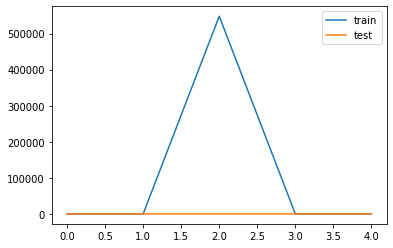

In [25]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Calling Tensorflow server

In [ ]:
input_data = np.array(np.random.random_sample([ 1, 50, 12]), dtype=np.float32) 

In [ ]:
model.predict(input_data)

In [30]:
import json
import requests
import numpy as np
import time

input_data = np.array(np.random.random_sample([1, 50, 12]), dtype=np.float32)

# create a json string to ask query to the depoyed model
data = json.dumps({
    "signature_name": "serving_default",
    "instances": input_data.tolist()
})

# headers for the post request
headers = {"content-type": "application/json"}

# make the post request 
start_time = time.time()

#18.221.185.88
json_response = requests.post('http://localhost:9000/v1/models/recognizer-user4/versions/1:predict',
                              data=data,
                              headers=headers)
elapsed_time = time.time() - start_time

# get the predictions
predictions = json.loads(json_response.text)
print(predictions)
print(elapsed_time)

{'predictions': [[0.483571738]]}
0.01758742332458496


In [35]:
import os
input_path = "/tmp/models/model1/train"

if not os.path.exists(input_path):
    os.makedirs(input_path)
    
with open("{}/SUCCESS".format(input_path), 'w') as fp: 
    pass

In [34]:
!ls input_path

ls: cannot access 'input_path': No such file or directory
